Model - Neural Network

In [158]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import pandas as pd
from sklearn.model_selection import train_test_split

In [159]:
class MyDataset(Dataset):
    def __init__ (self, file_path):
        self.data = pd.read_csv(file_path)
        self.features = self.data.iloc[:, 19:36].values
        self.labels = self.data.iloc[:, :3].values

    def __len__ (self):
        return len(self.data)
    
    def __getitem__ (self, idx):
        features = torch.tensor(self.features[idx], dtype=torch.float32) 
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return features, label

In [161]:
class MyModel(nn.Module):
    def __init__ (self, input_size, hidden_size, output_size):
        super (MyModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [162]:
file_path = '/Users/affanbinusman/Dropbox (ASU)/IRL-Lab/P&G/hackathon_data/watch_phone_motive_rec_2023-07-07_17-28-44.csv'
batch_size = 500
learning_rate = 0.001

In [163]:
dataset = MyDataset(file_path)

train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [164]:
input_size = len(dataset.features[0])
output_size = len(dataset.labels[0])
hidden_size = 128
model = MyModel(input_size, hidden_size, output_size)

criterion = nn.SmoothL1Loss() #mean square / regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [165]:
num_epochs = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MyModel(
  (fc1): Linear(in_features=17, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [166]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


Epoch 1/500, Loss: 13.764313849535855
Epoch 2/500, Loss: 2.268904771994461
Epoch 3/500, Loss: 0.35071398893540556
Epoch 4/500, Loss: 0.06420318570665338
Epoch 5/500, Loss: 0.02338911686092615
Epoch 6/500, Loss: 0.01751292623918165
Epoch 7/500, Loss: 0.015347103037956085
Epoch 8/500, Loss: 0.014186507429588924
Epoch 9/500, Loss: 0.012828192377293652
Epoch 10/500, Loss: 0.012175267604603008
Epoch 11/500, Loss: 0.011224380651996895
Epoch 12/500, Loss: 0.010457432574846527
Epoch 13/500, Loss: 0.010385144078596071
Epoch 14/500, Loss: 0.009878735185008158
Epoch 15/500, Loss: 0.010594426061619411
Epoch 16/500, Loss: 0.010986802887848833
Epoch 17/500, Loss: 0.00957161401906474
Epoch 18/500, Loss: 0.009248825149949302
Epoch 19/500, Loss: 0.009107721207494085
Epoch 20/500, Loss: 0.009253093824637208
Epoch 21/500, Loss: 0.011514145372943445
Epoch 22/500, Loss: 0.013232909481633793
Epoch 23/500, Loss: 0.07360773008655418
Epoch 24/500, Loss: 0.028582532636143944
Epoch 25/500, Loss: 0.01770924579944

In [168]:
model.eval()
total_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

mean_loss = total_loss / len(test_loader)
print(f"Smooth L1 Loss: {mean_loss}")

Smooth L1 Loss: 0.027201696299016476


Visualizations

correlation plots / pressure & y-pos hand
3d visualization of ground truth
distrubution of accelaration

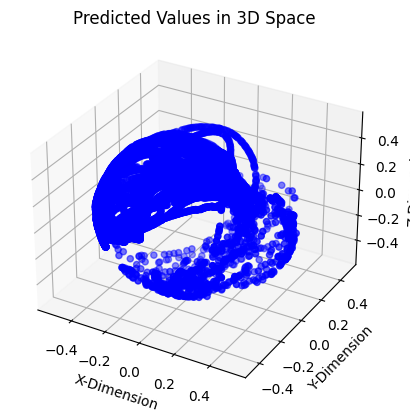

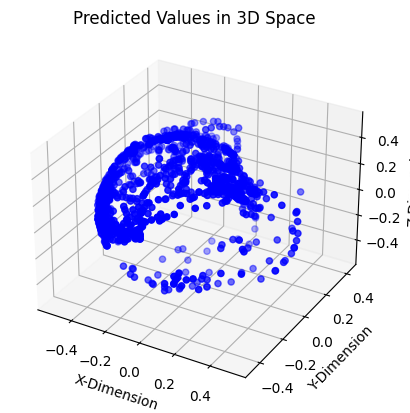

In [156]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import plotly.graph_objs as go

data = pd.read_csv(file_path)

output_visualization(data)
output_visualization(data, reduced=True, reduceby = 0.1)
interactive_output_visualization(data)
interactive_output_visualization(data, reduced=True, reduceby = 0.1)

In [155]:
def data_visualization(data, reduced = False, reduceby = None):
    dim1, dim2, dim3 = np.array(data.iloc[:, 0]), np.array(data.iloc[:, 1]), np.array(data.iloc[:, 2])

    if reduced == True:
        reduced_samples = int(reduceby * len(dim1))
        random_indices = np.random.choice(len(dim1), size=reduced_samples, replace=False)
        dim1, dim2, dim3 = dim1[random_indices], dim2[random_indices], dim3[random_indices]

    return dim1, dim2, dim3


def output_visualization(data, reduced = False, reduceby = None):

    dim1, dim2, dim3 = data_visualization(data, reduced, reduceby)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(dim1, dim2, dim3, c='b', marker='o')

    ax.set_xlabel('X-Dimension')
    ax.set_ylabel('Y-Dimension')
    ax.set_zlabel('Z-Dimension')
    ax.set_title('Predicted Values in 3D Space')

    plt.show()

def interactive_output_visualization(data, reduced = False, reduceby = None):
    dim1, dim2, dim3 = data_visualization(data, reduced, reduceby)
    
    trace = go.Scatter3d(
    x=dim1,
    y=dim2,
    z=dim3,
    mode='markers',
    marker=dict(
        size=5,
        color='blue',
        opacity=0.8
        )
    )

    layout = go.Layout(
    title='Predicted Values in 3D Space',
    scene=dict(
        xaxis=dict(title='X-Dimension'),
        yaxis=dict(title='Y-Dimension'),
        zaxis=dict(title='Z-Dimension')
        )
    )

    fig = go.Figure(data=[trace], layout=layout)
    fig.show()
    

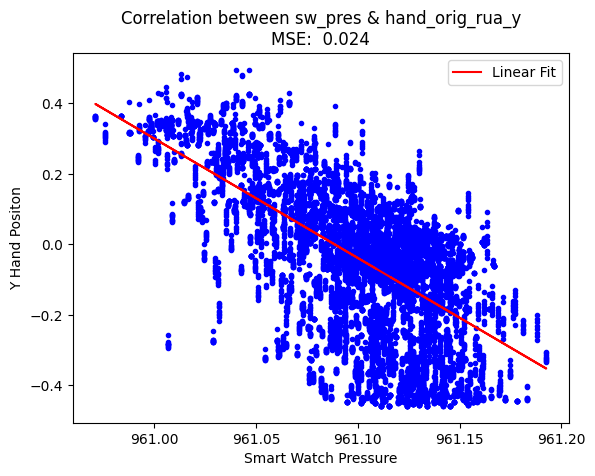

In [170]:
def correlationPlot(data):
    pressure_label = "sw_pres"  # Smart Watch Pressure
    yPos_label = "hand_orig_rua_y"    # Y Hand Position
    dim1, dim2 = np.array(data[pressure_label]), np.array(data[yPos_label])
    dim1, dim2 = dim1[1:], dim2[1:]
    
    slope, intercept = np.polyfit(dim1, dim2, deg=1)
    regression_line = slope * dim1 + intercept

    mse = np.mean((dim2 - regression_line)**2)

    plt.scatter(dim1, dim2, c='b', marker='.')
    plt.plot(dim1, regression_line, c='r', label='Linear Fit')
    plt.xlabel("Smart Watch Pressure")
    plt.ylabel("Y Hand Positon")
    plt.title(f"Correlation between {pressure_label} & {yPos_label}\nMSE: {mse: .3f}")
    plt.legend()
    plt.show()

correlationPlot(data)

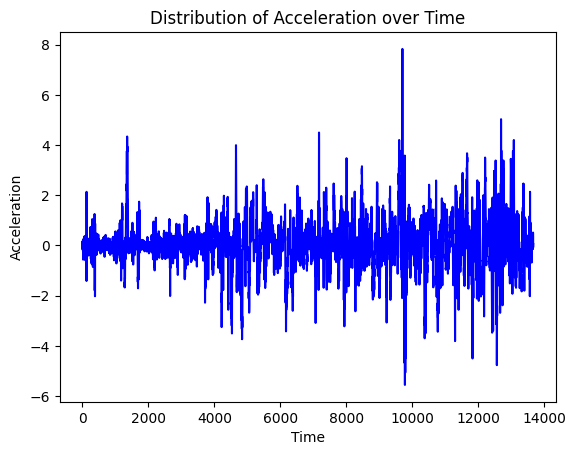

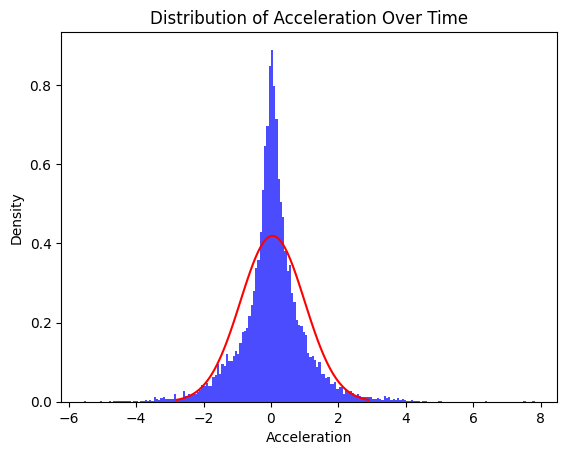

In [172]:
def accDistPlot(data):
    column_name = "sw_lacc_y"  
    acceleration_values = data[column_name]
    
    plt.plot(list(range(1, 1 + len(acceleration_values))), acceleration_values, color= 'b')
    plt.xlabel("Time")
    plt.ylabel("Acceleration")
    plt.title("Distribution of Acceleration over Time")
    plt.show()

    mean_acceleration = np.mean(acceleration_values)
    std_acceleration = np.std(acceleration_values)
    plt.hist(acceleration_values, bins='auto', density=True, alpha=0.7, color='b')
    x = np.linspace(mean_acceleration - 3 * std_acceleration, mean_acceleration + 3 * std_acceleration, 100)
    y = (1 / (std_acceleration * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean_acceleration) / std_acceleration) ** 2)
    plt.plot(x, y, color='r')
    plt.title('Distribution of Acceleration Over Time')
    plt.xlabel('Acceleration')
    plt.ylabel('Density')

    plt.show()

accDistPlot(data)